In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
from numpy import genfromtxt

In [3]:
mask_data = genfromtxt("data/mask/msk_300.csv", delimiter =',')

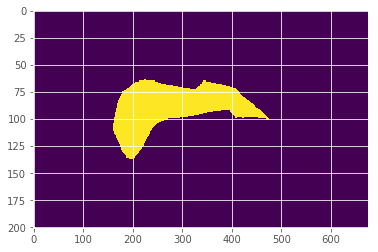

In [4]:
mask_data = mask_data.reshape(676,201)
plt.imshow(mask_data.T, cmap="viridis", vmin=0, vmax=1, aspect='auto')
plt.show()

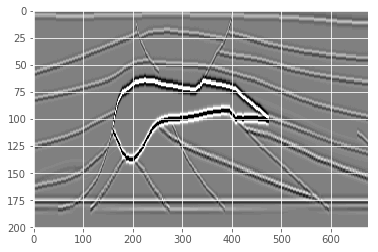

In [5]:
img_data = genfromtxt("data/image/img_300.csv", delimiter =',')
img_data = img_data.reshape(676,201)
vm = np.percentile(img_data, 99)
plt.imshow(img_data.T, cmap="gray", vmin=-vm, vmax=vm, aspect='auto')
plt.show()

In [6]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

In [7]:
ids = next(os.walk("data/image"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  676


In [8]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

#### Load the images and masks into arrays

In [9]:
ids = next(os.walk("data/image"))[2] # list of names all images in the given path
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = np.loadtxt(open("data/image/"+id_, "rb"), delimiter= ',')
    x_img = img.T
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
#ids = next(os.walk("data/mask"))[2] # list of names all images in the given path  
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load mask
    id_ = "msk_"+id_[-7:]
    mask = np.loadtxt(open("data/mask/"+id_, "rb"), delimiter= ',')
    mask = mask.T
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)    
    # Save mask
    
    y[n] = mask

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [11]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

#### Below code can be used to visualize the images and corresponding masks

Text(0.5, 1.0, 'Salt')

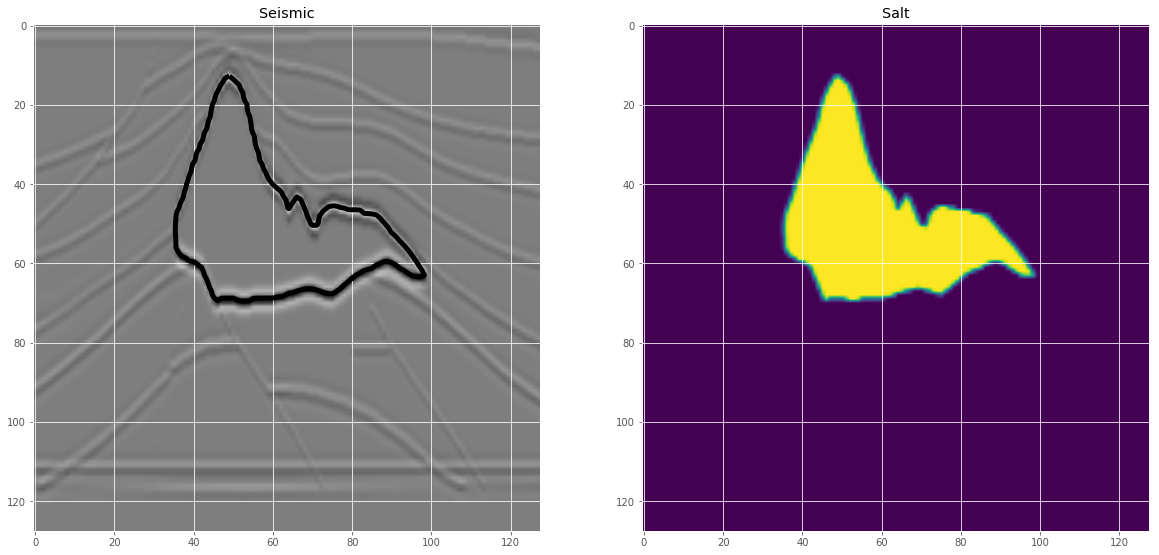

In [12]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'viridis', interpolation = 'bilinear')
ax2.set_title('Salt')

In [15]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [13]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = False):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [16]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 128, 128, 16) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [18]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('2d-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [19]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Train on 608 samples, validate on 68 samples
Epoch 1/50
608/608 [==============================] - 72s 118ms/step - loss: 0.5446 - accuracy: 0.8364 - val_loss: 2.6539 - val_accuracy: 0.1923

Epoch 00001: val_loss improved from inf to 2.65395, saving model to 2d-salt.h5
Epoch 2/50
608/608 [==============================] - 66s 108ms/step - loss: 0.2931 - accuracy: 0.9773 - val_loss: 3.3946 - val_accuracy: 0.2029

Epoch 00002: val_loss did not improve from 2.65395
Epoch 3/50
608/608 [==============================] - 66s 109ms/step - loss: 0.2165 - accuracy: 0.9811 - val_loss: 0.4177 - val_accuracy: 0.9090

Epoch 00003: val_loss improved from 2.65395 to 0.41766, saving model to 2d-salt.h5
Epoch 4/50
608/608 [==============================] - 67s 109ms/step - loss: 0.1782 - accuracy: 0.9814 - val_loss: 0.2745 - val_accuracy: 0.9568

Epoch 00004: val_loss improved from 0.41766 to 0.27453, saving model to 2d-salt.h5
Epoch 5/50
608/608 [==============================] - 66s 109ms/step - loss


Epoch 00036: val_loss improved from 0.01382 to 0.01307, saving model to 2d-salt.h5
Epoch 37/50
608/608 [==============================] - 67s 111ms/step - loss: 0.0135 - accuracy: 0.9814 - val_loss: 0.0128 - val_accuracy: 0.9792

Epoch 00037: val_loss improved from 0.01307 to 0.01283, saving model to 2d-salt.h5
Epoch 38/50
608/608 [==============================] - 67s 110ms/step - loss: 0.0130 - accuracy: 0.9814 - val_loss: 0.0123 - val_accuracy: 0.9792

Epoch 00038: val_loss improved from 0.01283 to 0.01226, saving model to 2d-salt.h5
Epoch 39/50
608/608 [==============================] - 67s 111ms/step - loss: 0.0125 - accuracy: 0.9814 - val_loss: 0.0118 - val_accuracy: 0.9792

Epoch 00039: val_loss improved from 0.01226 to 0.01175, saving model to 2d-salt.h5
Epoch 40/50
608/608 [==============================] - 68s 112ms/step - loss: 0.0122 - accuracy: 0.9814 - val_loss: 0.0116 - val_accuracy: 0.9792

Epoch 00040: val_loss improved from 0.01175 to 0.01158, saving model to 2d-salt

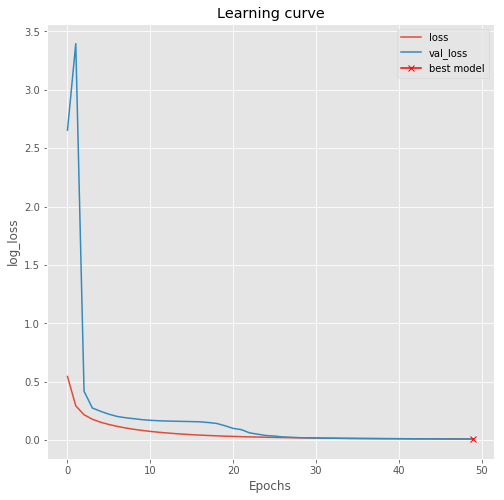

In [20]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### Inference

In [21]:
# load the best model
model.load_weights('2d-salt.h5')

In [22]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

68/68 [==============================] - 2s 26ms/step


[0.008706003044019727, 0.9791789054870605]

In [23]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

68/68 [==============================] - 2s 29ms/step


In [24]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [25]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

### Predictions on training set

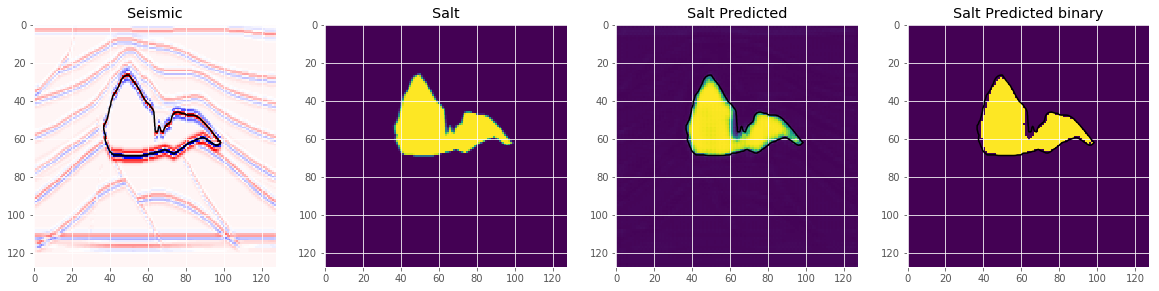

In [63]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

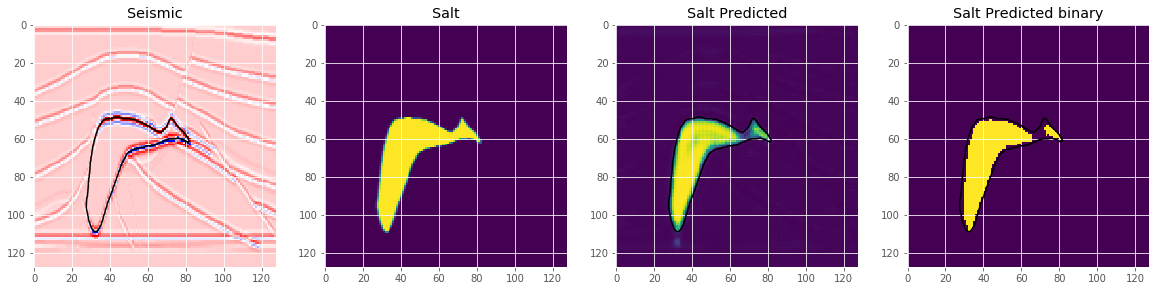

In [65]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

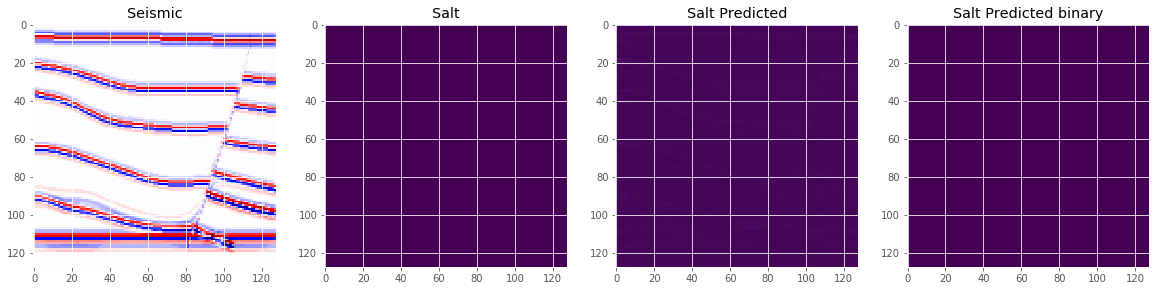

In [66]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

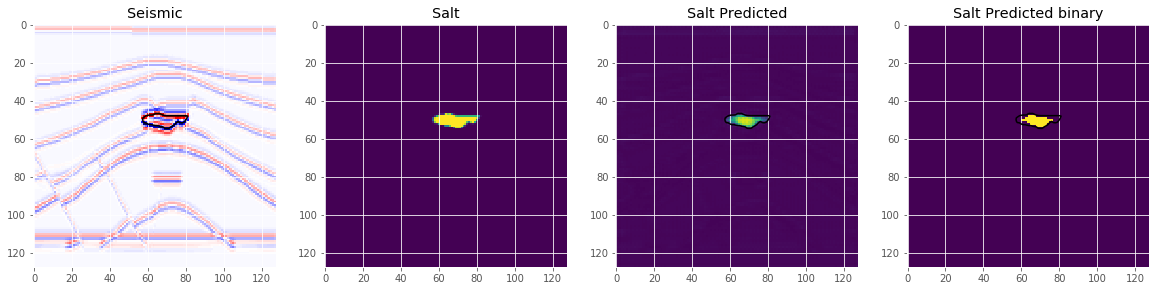

In [67]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

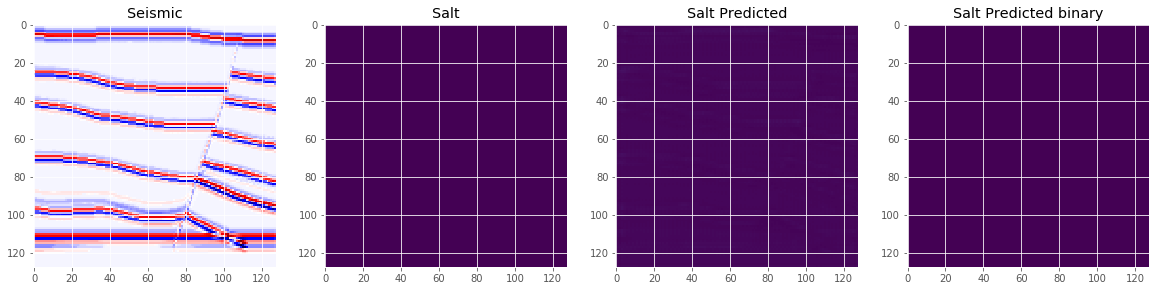

In [68]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

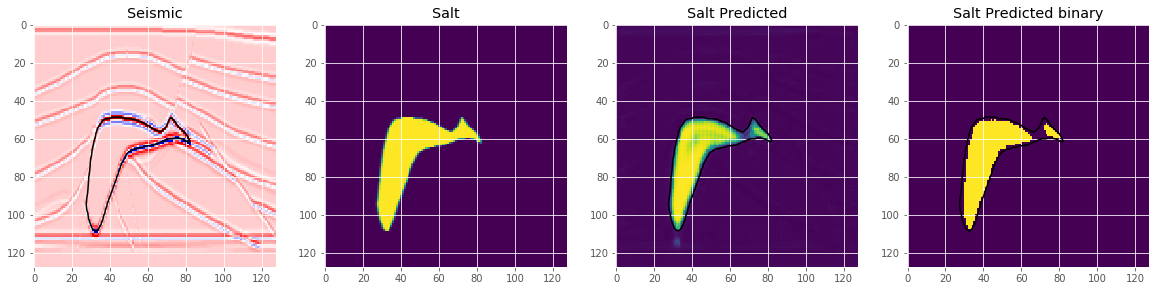

In [69]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

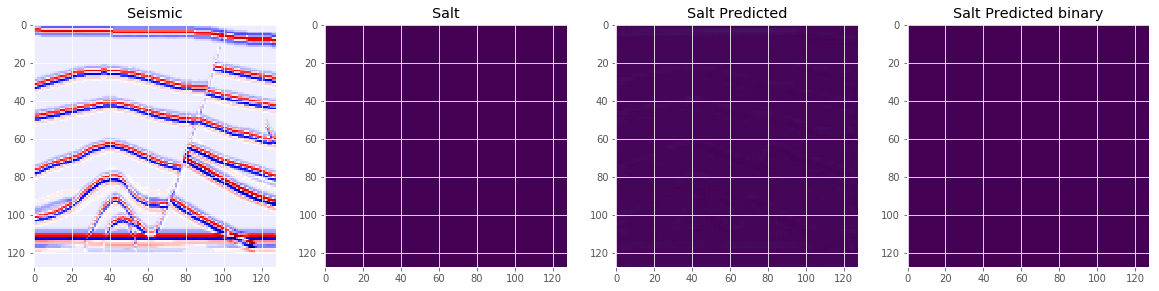

In [70]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

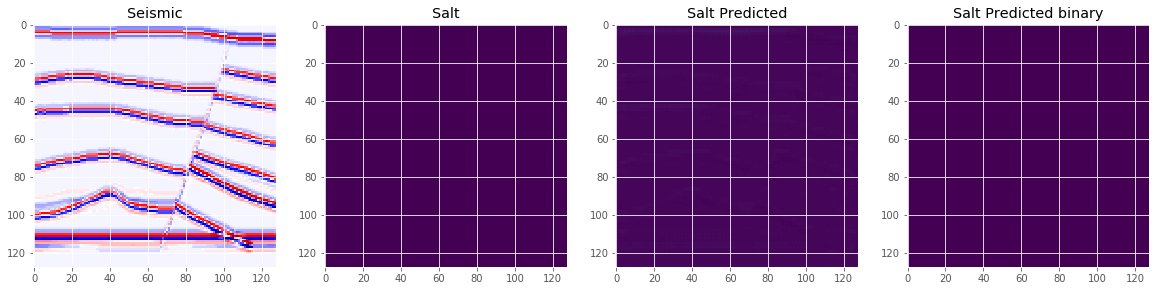

In [71]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

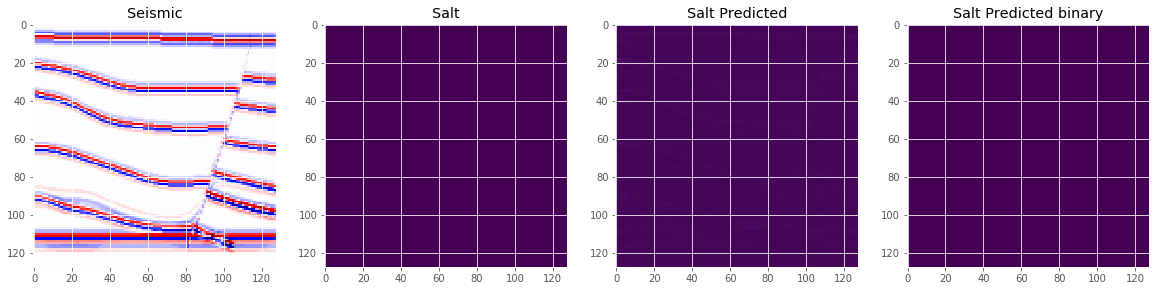

In [72]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

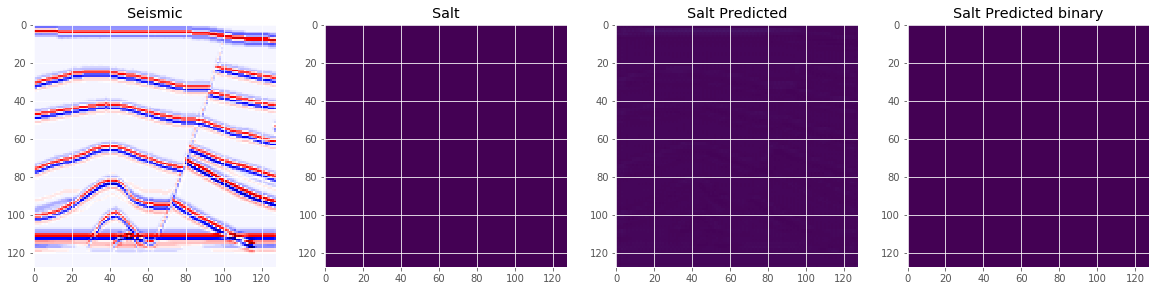

In [73]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

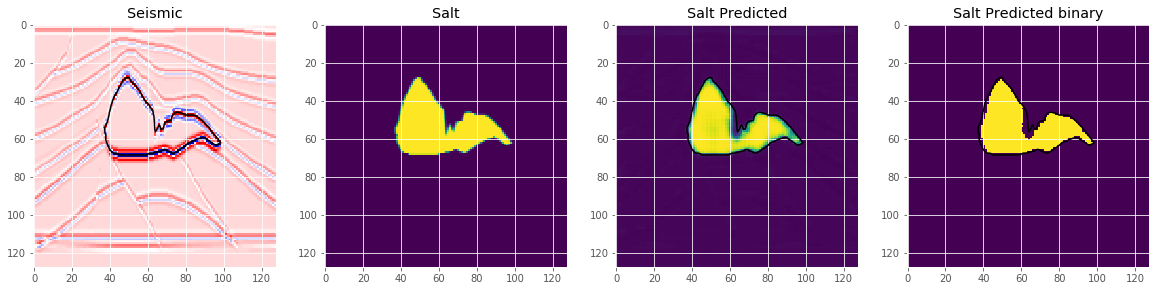

In [74]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

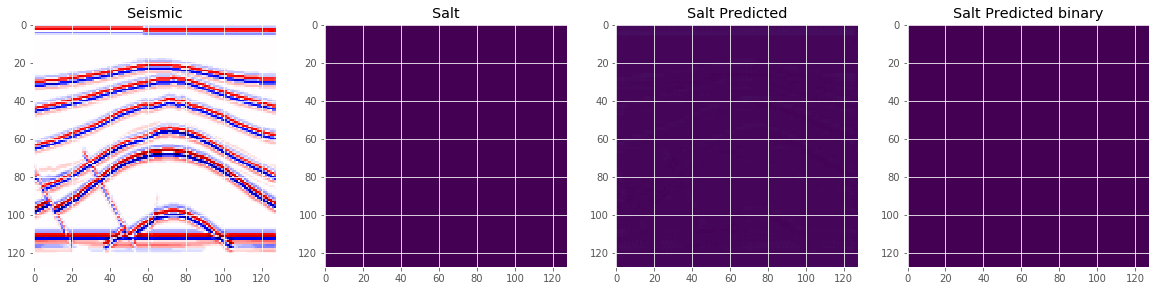

In [75]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

### Predictions on test set

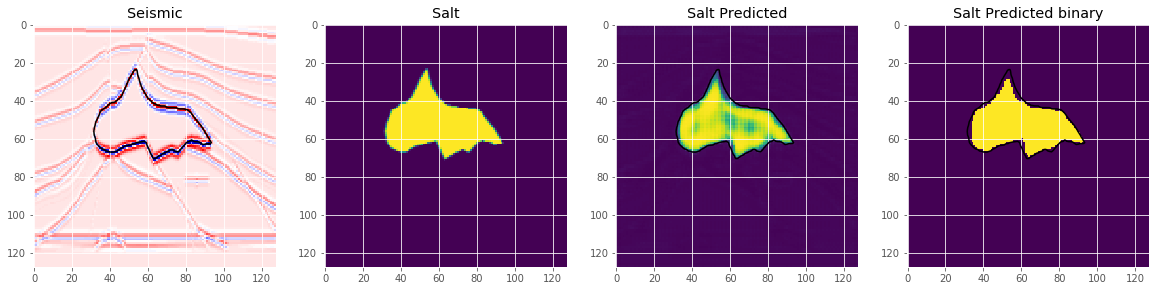

In [76]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

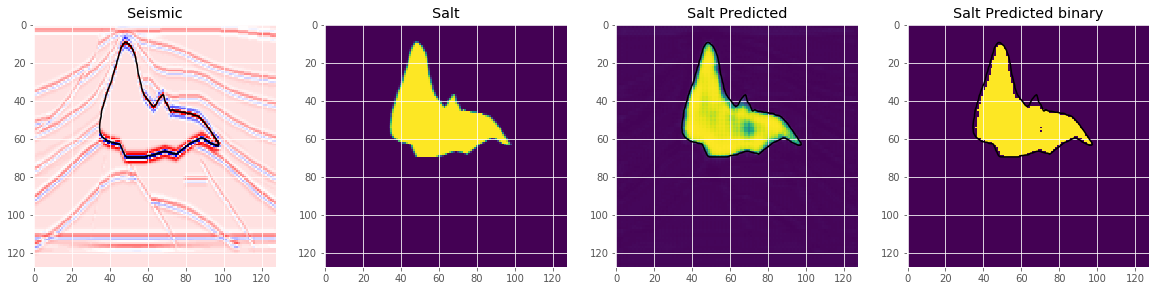

In [77]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

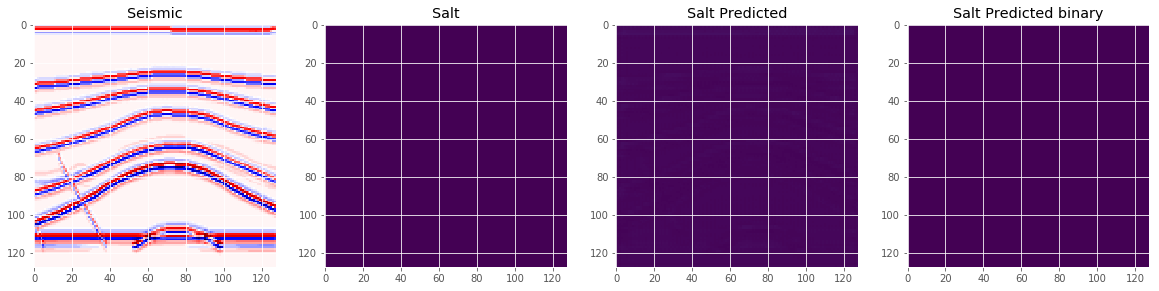

In [78]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

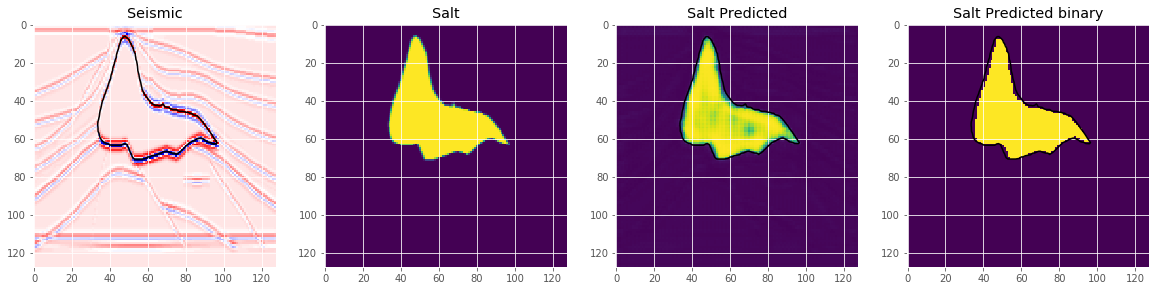

In [79]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

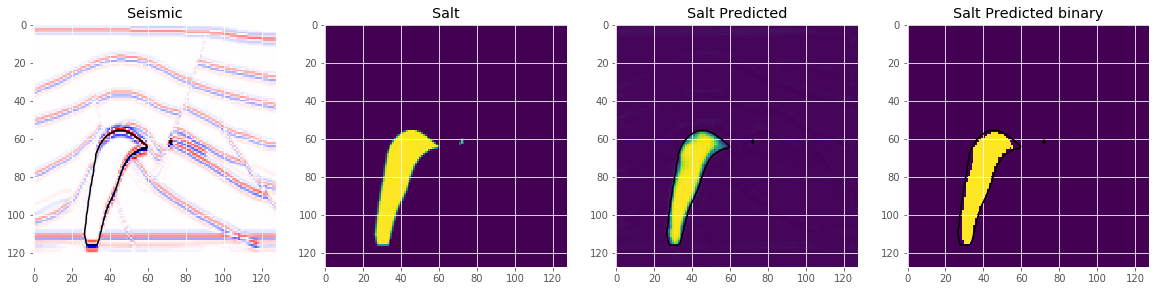

In [80]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

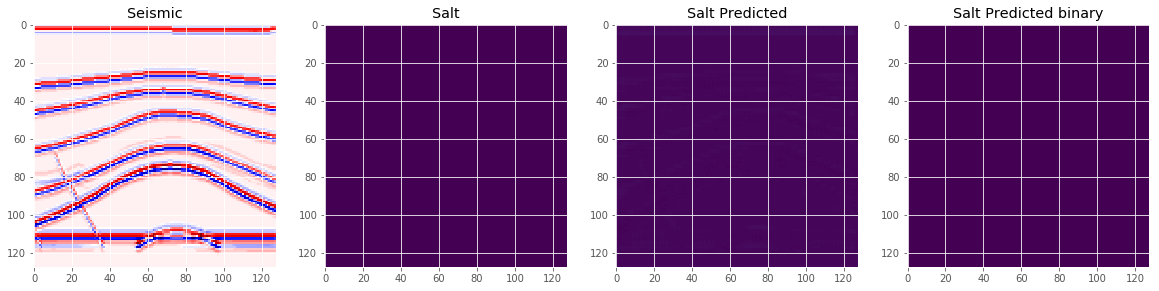

In [81]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

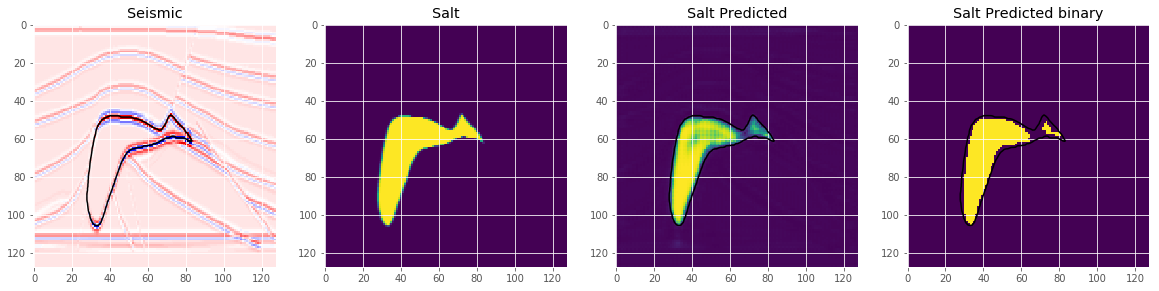

In [82]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

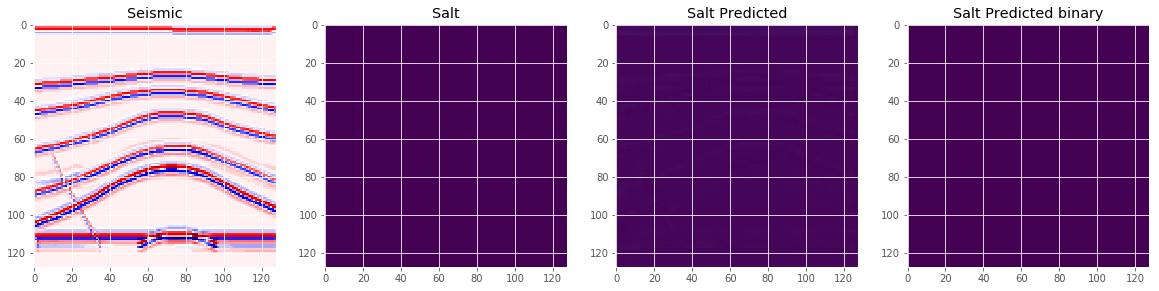

In [83]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

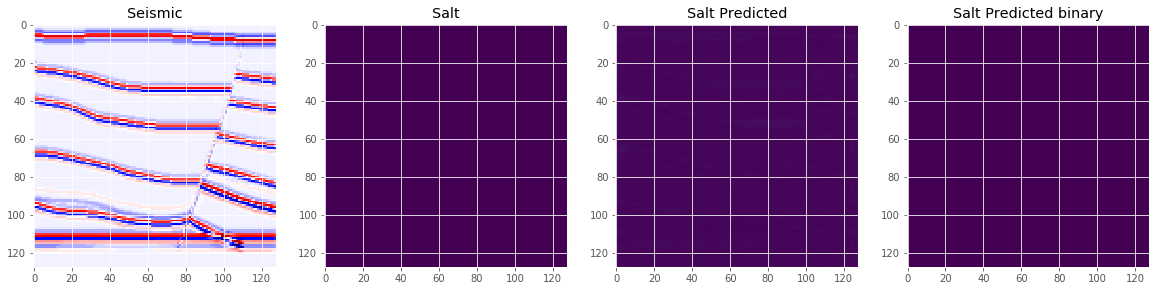

In [84]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

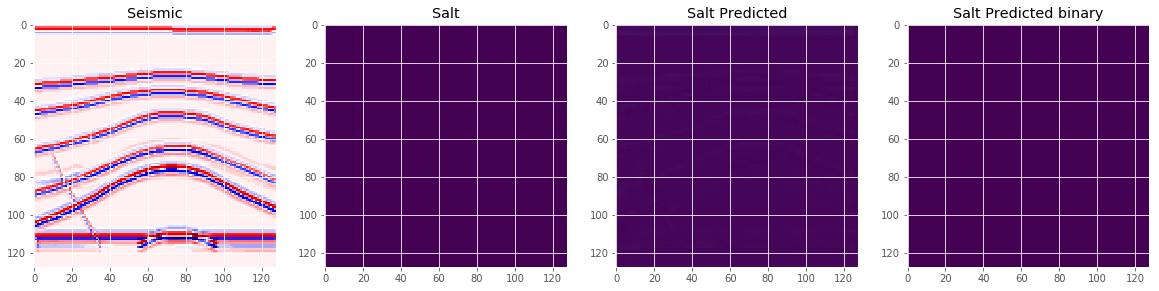

In [85]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

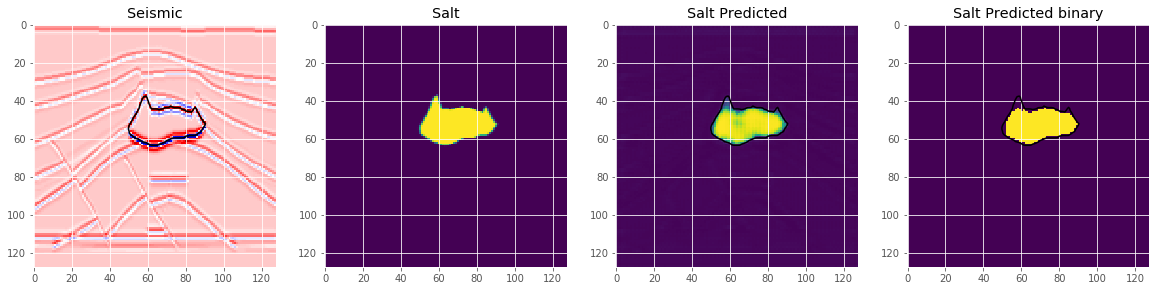

In [86]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

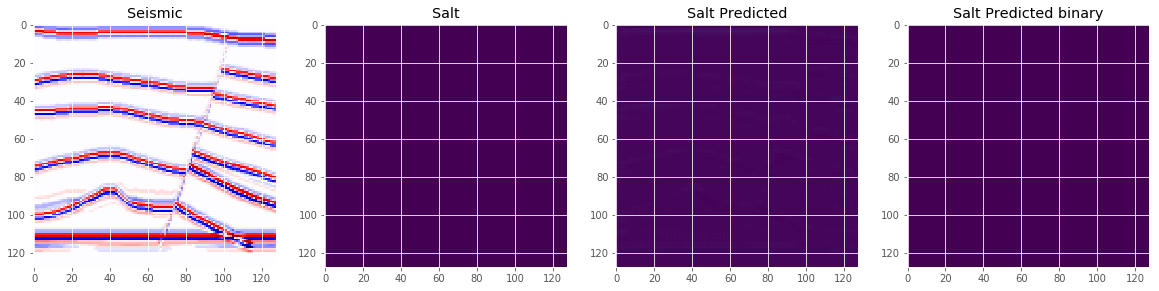

In [87]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

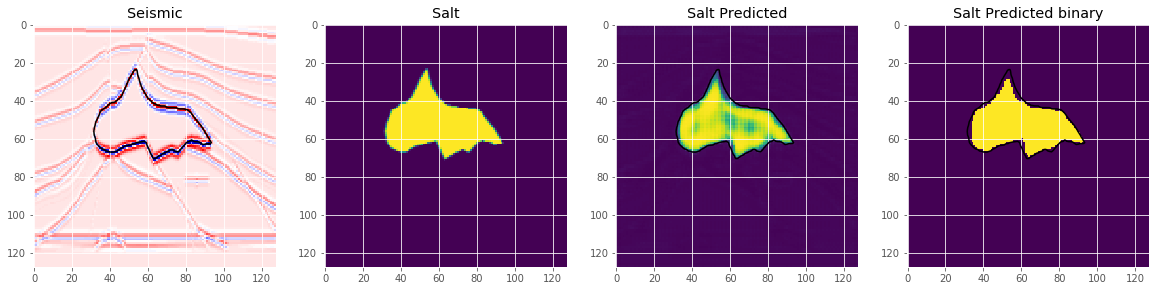

In [88]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

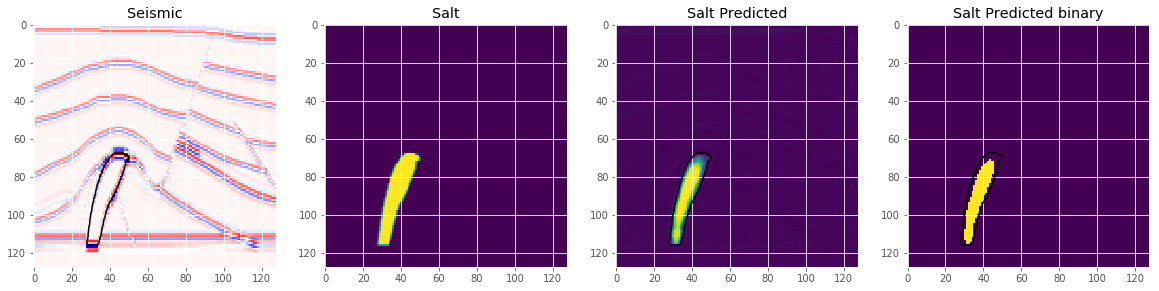

In [89]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

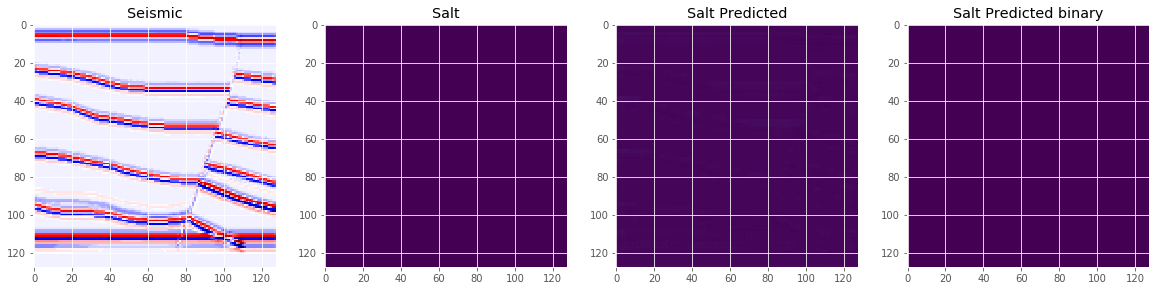

In [90]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

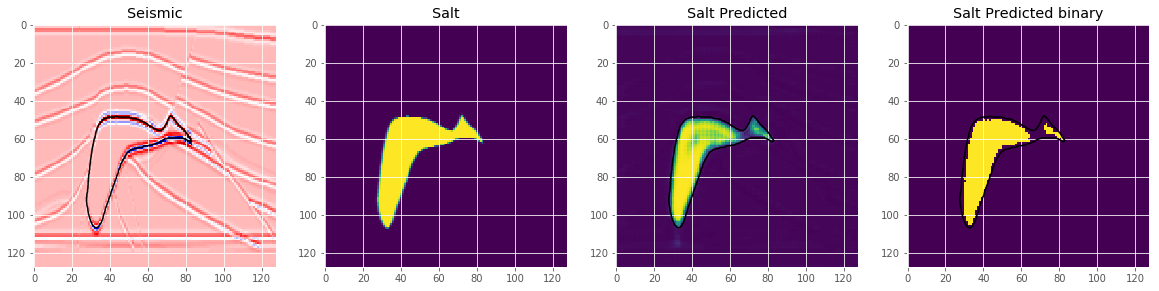

In [91]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)